In [1]:
import toml
import numba
import joblib
import random
import warnings
import numpy as np
import pandas as pd
import colorcet as cc
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal
from toolz import get, partial
from os.path import join
from tqdm.auto import tqdm
from rl_analysis.bootstraps import bootstrap_ci
from tqdm.contrib.concurrent import process_map
from rl_analysis.io.df import NONSYLL_COLS, dlight_exclude_toml
from rl_analysis.behavior.moseq import syll_onset, add_onset_and_duration
from rl_analysis.photometry.windowing import (
    window_trials_as_df,
    window_trials_as_mtx,
    window_trials_for_decoder,
)
from rl_analysis.plotting import (
    save_factory,
    add_legend,
    bootstrap_lineplot,
    setup_plotting_env,
    clean_ticks,
    COLORS,
    fg,
)
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

numba.set_num_threads(6)
warnings.simplefilter("ignore")

In [2]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'turning-syllables'), tight_layout=False)

In [3]:
color_map = {
    "Turn right": cc.glasbey[3],
    "Turn left 2": cc.glasbey[6],
}

syllable_map = {
    "Turn right": 25,
    "Turn left 2": 72,
}
dlight_key = config['dlight_basic_analysis']['dlight_key']

## Load data

In [4]:
def dlight_filter(ser):
    soscoeffs = signal.bessel(1, 1 / (30 / 2.), btype="high", output="sos")
    sig = ser.dropna()
    new_ser = pd.Series(index=ser.index)
    new_ser.loc[sig.index] = signal.sosfiltfilt(soscoeffs, sig)
    return new_ser

In [5]:
use_dct = dlight_exclude_toml(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.toml'),
    **config["dlight_common"]
)

df = pd.read_parquet(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.parquet'),
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

df = df[~df['session_number'].isin([3, 4])]
df = df.drop(columns=NONSYLL_COLS[3:])
df = df.sort_index()

df['offline onset'] = False
df.loc[df.index[syll_onset(df['predicted_syllable (offline)'])], 'offline onset'] = True
df['velocity_2d_mm'] = df['velocity_2d_mm'].astype(float)
df = add_onset_and_duration(df, syll_key='predicted_syllable (offline)')

df["dlight filtered"] = df.groupby("uuid", sort=False, observed=True)[
    "signal_reref_dff_z"
].transform(dlight_filter)

In [6]:
time_window = (-1.5, 1.5)

In [7]:
def shuffle(i, val, inds):
    time, trials = window_trials_as_mtx(
        pd.DataFrame(val, columns=[dlight_key]),
        inds + np.array(list(map(lambda v: random.randint(-60, 60), range(len(inds))))),
        dlight_key,
        truncation_window=time_window,
    )
    return np.nanmean(trials, axis=0)


def zscore_re_shuffle(trial_df, shuffle):
    mu = np.nanmean(shuffle, axis=0)
    sig = np.nanstd(shuffle, axis=0)

    trial_df["z_dlight"] = trial_df.groupby("trials")["dlight"].transform(lambda d: (d - mu) / sig)
    return trial_df

In [8]:
n_shuffles = 1_000
syll_key = "predicted_syllable (offline)"
dlight_key = "dlight filtered"

In [9]:
datas = {}

for syll_name, syll in tqdm(syllable_map.items()):
    inds = np.where(df["offline onset"] & (df[syll_key] == syll))[0]

    shuff = np.array(process_map(
        partial(shuffle, val=df[dlight_key], inds=inds),
        range(n_shuffles),
        max_workers=6,
    ))

    # dLight
    _, trial_df = window_trials_as_df(
        df,
        inds,
        dlight_key,
        truncation_window=time_window,
    )
    trial_df = zscore_re_shuffle(trial_df, shuff)
    trial_df["type"] = syll_name

    # velocity
    _, vel_trial_df = window_trials_as_df(
        df,
        np.where(df["offline onset"] & (df[syll_key] == syll))[0],
        "velocity_2d_mm",
        syll_key,
        truncation_window=time_window,
    )

    bootstraps = {}
    # bootstrap
    for key in ("dlight", "z_dlight"):
        b1 = trial_df.pivot_table(index="trials", columns="time", values=key)
        mu = b1.mean()
        b1 = bootstrap_ci(b1.to_numpy(), n_shuffles)
        b1 = pd.DataFrame(b1.T, index=mu.index)
        b1 = b1.reset_index().melt(var_name="boot", id_vars="time", value_name="dlight")
        b1["type"] = syll_name
        prefix = "z_" if "z_" in key else ""
        bootstraps[f"{prefix}bootstrap"] = b1
        bootstraps[f"{prefix}mean"] = mu

    v = vel_trial_df.pivot_table(index="trials", columns="time", values="dlight")
    v = bootstrap_ci(v.to_numpy(), n_shuffles)
    v = pd.DataFrame(v.T, index=mu.index)
    v = v.reset_index().melt(var_name="boot", id_vars="time", value_name="velocity")
    v["type"] = syll_name

    # save output
    datas[syll] = {
        "syllable name": syll_name,
        "syllable id": syll,
        "shuffles": shuff,
        "aligned dlight": trial_df,
        "aligned velocity": vel_trial_df,
        "n_shuffs": n_shuffles,
        "velocity_bootstrap": v,
        **bootstraps,
    }

joblib.dump(
    datas,
    join(config['intermediate_results']['dlight'], "turning-syllable-filtered-waveforms-panel.p"),
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

['/n/groups/datta/win/dopamine-data-release/zenodo-test/dlight_intermediate_results/turning-syllable-filtered-waveforms-panel.p']

In [10]:
# instead of re-running calculation above, load in previous one
# datas = joblib.load(
#     join(config['intermediate_results']['dlight'], "turning-syllable-filtered-waveforms-panel.p"),
# )

In [11]:
list((x['syllable name'], x['syllable id']) for x in datas.values())

[('Turn right', 25), ('Turn left 2', 72)]

## Panel: different dLight similar kinematics - dLight

In [12]:
different_da_sylls = [25, 72]

In [13]:
shuff_line = []
for _data in get(different_da_sylls, datas):
    shuffs = _data['shuffles']
    shuff_line.append(
        (shuffs - np.nanmean(shuffs, 0, keepdims=True)) / np.nanstd(shuffs, 0, keepdims=True)
    )
shuff_line = pd.DataFrame(np.concatenate(shuff_line, axis=0).T, index=_data['mean'].index)
shuff_line = shuff_line.reset_index().melt(var_name='boot', id_vars='time', value_name='dlight')

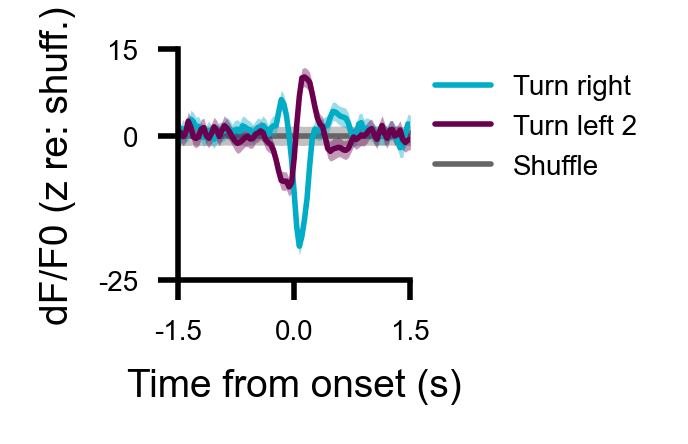

In [14]:
fig = fg(0.75, 0.75)
fig.dpi = 200
for _data in get(different_da_sylls, datas):
    ax = bootstrap_lineplot(
        _data["z_bootstrap"],
        "time",
        "dlight",
        ci=95,
        color=color_map[_data["syllable name"]],
        label=_data["syllable name"],
        alpha=0.4,
    )

bootstrap_lineplot(
    shuff_line, "time", "dlight", ci=95, color=(0.4,) * 3, label="Shuffle", alpha=0.4, zorder=-2
)

add_legend(ax)
plt.ylabel("dF/F0 (z re: shuff.)")
plt.xlabel("Time from onset (s)")
plt.xlim(-1.5, 1.5)
plt.ylim(-25, 15)
clean_ticks(ax, "y", dtype=int, precision=0, zero_symmetry=False)
clean_ticks(ax, "x", dtype=float)
sns.despine()
saver(fig, "turning-syllables-z-re-shuffle");

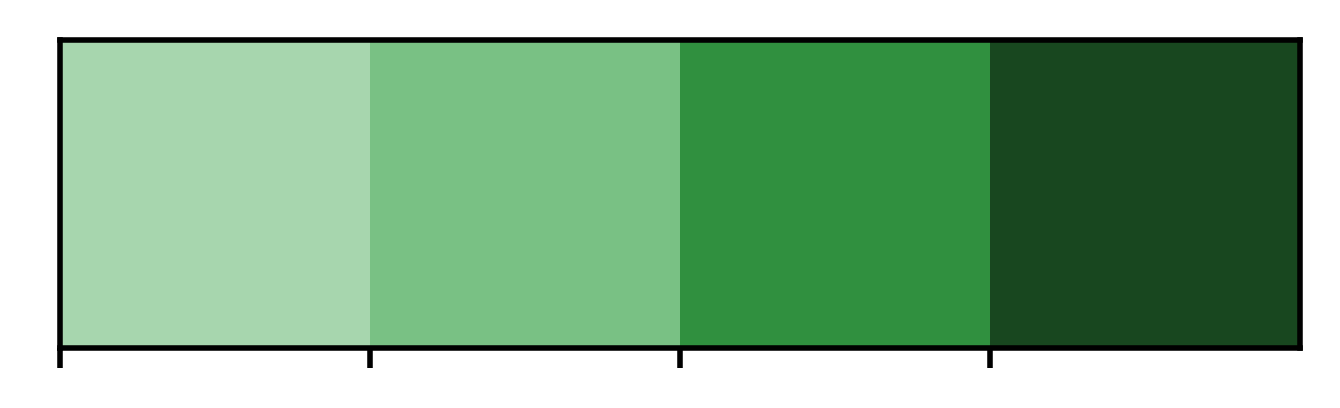

In [15]:
cmap = sns.blend_palette(['#fff', COLORS['green'], '#000'], 10)
cmap = np.array(cmap)[[2, 3, 5, 7]]

sns.palplot(cmap)

  0%|          | 0/2 [00:00<?, ?it/s]

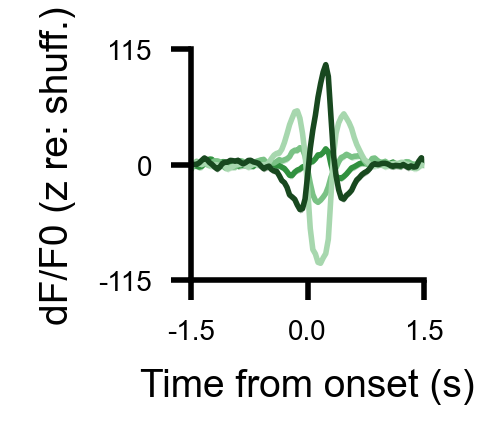

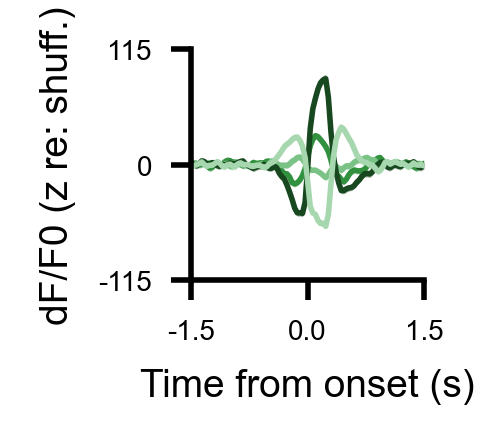

In [16]:
for _data in tqdm(get(different_da_sylls, datas)):
    pos_dlight = (
        _data["aligned dlight"]
        .groupby("trials", sort=False)
        .apply(lambda v: v.query("time > 0 & time < 0.3")["z_dlight"].max())
    )
    qs = pd.qcut(pos_dlight, 4, labels=False).astype("Int8")

    fig = fg(0.75, 0.75)
    fig.dpi = 200

    for q, _df in _data["aligned dlight"].groupby(
        _data["aligned dlight"]["trials"].map(qs), sort=False, dropna=True
    ):
        b1 = _df.query("time >= -1.5 & time <= 1.5").pivot_table(
            index="trials", columns="time", values='z_dlight'
        )
        mu = b1.mean()
        b1 = bootstrap_ci(b1.to_numpy(), n_shuffles)
        b1 = pd.DataFrame(b1.T, index=mu.index)
        b1 = b1.reset_index().melt(var_name="boot", id_vars="time", value_name="dlight")
        ax = bootstrap_lineplot(
            b1, "time", "dlight", ci=95, color=cmap[q], label=_data["syllable name"], alpha=0.4
        )
    sns.despine()
    plt.ylabel("dF/F0 (z re: shuff.)")
    plt.xlabel("Time from onset (s)")
    plt.xlim(-1.5, 1.5)
    plt.ylim(-115, 115)
    clean_ticks(ax, "y", dtype=int, precision=0, zero_symmetry=False)
    clean_ticks(ax, "x", dtype=float)
    sns.despine()
    saver(fig, f"turning-syllable-{_data['syllable id']}-quartiles");

## Decode turning?

In [17]:
turning_sylls = {
    95: "left",
    72: "left",
    71: "left",
    22: "left",
    19: "right",
    8:  "right",
    25: "right",
    33: "right",
}

In [18]:
dlight_key = "signal_reref_dff_z"

trial_df = window_trials_for_decoder(
    df,
    np.where(
        df["offline onset"]
        & (df["predicted_syllable (offline)"].isin(list(turning_sylls)))
        & (df["dur"] > 4)
    )[0],
    dlight_key,
    "predicted_syllable (offline)",
    truncation_window=(0, 0.3),
)
trial_df["syllable"] = trial_df["syllable"].map(turning_sylls)
trial_df = trial_df.dropna()

In [19]:
max_sample_size = trial_df['syllable'].value_counts().min() // 3

In [20]:
n_splits = 5
folds = StratifiedKFold(n_splits=n_splits)

metrics = []

pbar = tqdm(range(10))
for i in pbar:
    sample = trial_df.groupby("syllable").apply(
        lambda v: v.sample(n=max_sample_size, replace=False)
    )
    for j, (train_idx, test_idx) in enumerate(folds.split(sample, sample["syllable"])):
        train = sample.iloc[train_idx]
        test = sample.iloc[test_idx]

        mdl = LinearSVC()
        mdl.fit(train.drop(columns=["syllable"]), train["syllable"])
        pred = mdl.predict(test.drop(columns=["syllable"]))

        metrics.append(
            {
                "accuracy": accuracy_score(test["syllable"], pred),
                "f1": f1_score(test["syllable"], pred, average="macro"),
                "fold": j,
                "repeat": i,
            }
        )
    tmp = pd.DataFrame(metrics)["accuracy"].mean()
    pbar.set_description(f"accuracy: {tmp:0.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
metrics = pd.DataFrame(metrics)
metrics.head()

,accuracy,f1,fold,repeat
0,0.516659,0.515992,0,0
1,0.511030,0.509817,1,0
2,0.518411,0.517439,2,0
3,0.519629,0.519035,3,0
4,0.509434,0.508653,4,0


In [ ]:
# shuffle
n_splits = 5
folds = StratifiedKFold(n_splits=n_splits)

shuff_metrics = []

pbar = tqdm(range(100))
for i in pbar:
    sample = trial_df.groupby("syllable").apply(
        lambda v: v.sample(n=max_sample_size, replace=False)
    )
    sample["syllable"] = np.random.permutation(sample["syllable"])
    for j, (train_idx, test_idx) in enumerate(folds.split(sample, sample["syllable"])):
        train = sample.iloc[train_idx]
        test = sample.iloc[test_idx]

        mdl = LinearSVC()
        mdl.fit(train.drop(columns=["syllable"]), train["syllable"])
        pred = mdl.predict(test.drop(columns=["syllable"]))

        shuff_metrics.append(
            {
                "accuracy": accuracy_score(test["syllable"], pred),
                "f1": f1_score(test["syllable"], pred, average="macro"),
                "fold": j,
                "repeat": i,
            }
        )
    tmp = pd.DataFrame(shuff_metrics)["accuracy"].mean()
    pbar.set_description(f"accuracy: {tmp:0.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
shuff_metrics = pd.DataFrame(shuff_metrics)
shuff_metrics.head()

In [ ]:
fig = fg(0.5, 0.8)
fig.dpi = 200
ax = sns.boxplot(
    data=[metrics["accuracy"], shuff_metrics["accuracy"]], showfliers=False, showcaps=False
)
ax.set(ylabel="Accuracy", xticklabels=["Observed", "Shuffle"], ylim=(0, 1))
clean_ticks(ax, axis="y", dtype=int)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "turning-classifier");